In [1]:
from lab.postprocessing.toolbox import load_model
model ,loader = load_model("/home/iailab36/aliakbar/rnn-cnn/scripts/results/cifar/Res18_LSTM_dim9+threshold0.8_model_lstm_dim_9_model_max_rec_2/","0717-195627",device='cpu')
# model_mlp ,loader_1 = load_model("/home/iailab36/aliakbar/rnn-cnn/scripts/results/cifar/resnet/resnet_RNN_dim_10_rec_2/","0718-121833")

Files already downloaded and verified


In [2]:
import torch
a= (list(model.children())[0])
b=(list(a.children())[:7])
f = torch.nn.Sequential(*b)
f = f.to("cpu")

In [19]:
all_features = []
all_features = torch.tensor(all_features)
f_steps = []
f_steps = torch.tensor(f_steps)
all_labels = []
all_labels = torch.tensor(all_labels)
all_logits = []
all_logits = torch.tensor(all_logits)
for batch in loader.valid:
    labels = batch[1]
    input= batch[0].to("cpu")
    features = f(input)
    logits_stacked, final_steps = model(input)
    
    all_labels = torch.cat((all_labels,labels),0)
    f_steps = torch.cat((f_steps,final_steps),0)
    all_features = torch.cat((all_features,features),0)
    all_logits = torch.cat((all_logits,logits_stacked),1)
print(all_features.size())
all_features = torch.flatten(all_features, 1)

torch.Size([5000, 512, 1, 1])


In [20]:
all_logits.size()

torch.Size([2, 5000, 10])

In [41]:
prediction = model.get_final_logits(all_logits,f_steps.type(torch.long))
prediction = torch.argmax(prediction,dim=1)


In [42]:
resul = prediction == all_labels
prediction.size()

torch.Size([5000])

In [5]:
import numpy as np
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(all_features.cpu())
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]


/home/iailab36/aliakbar/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/iailab36/aliakbar/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


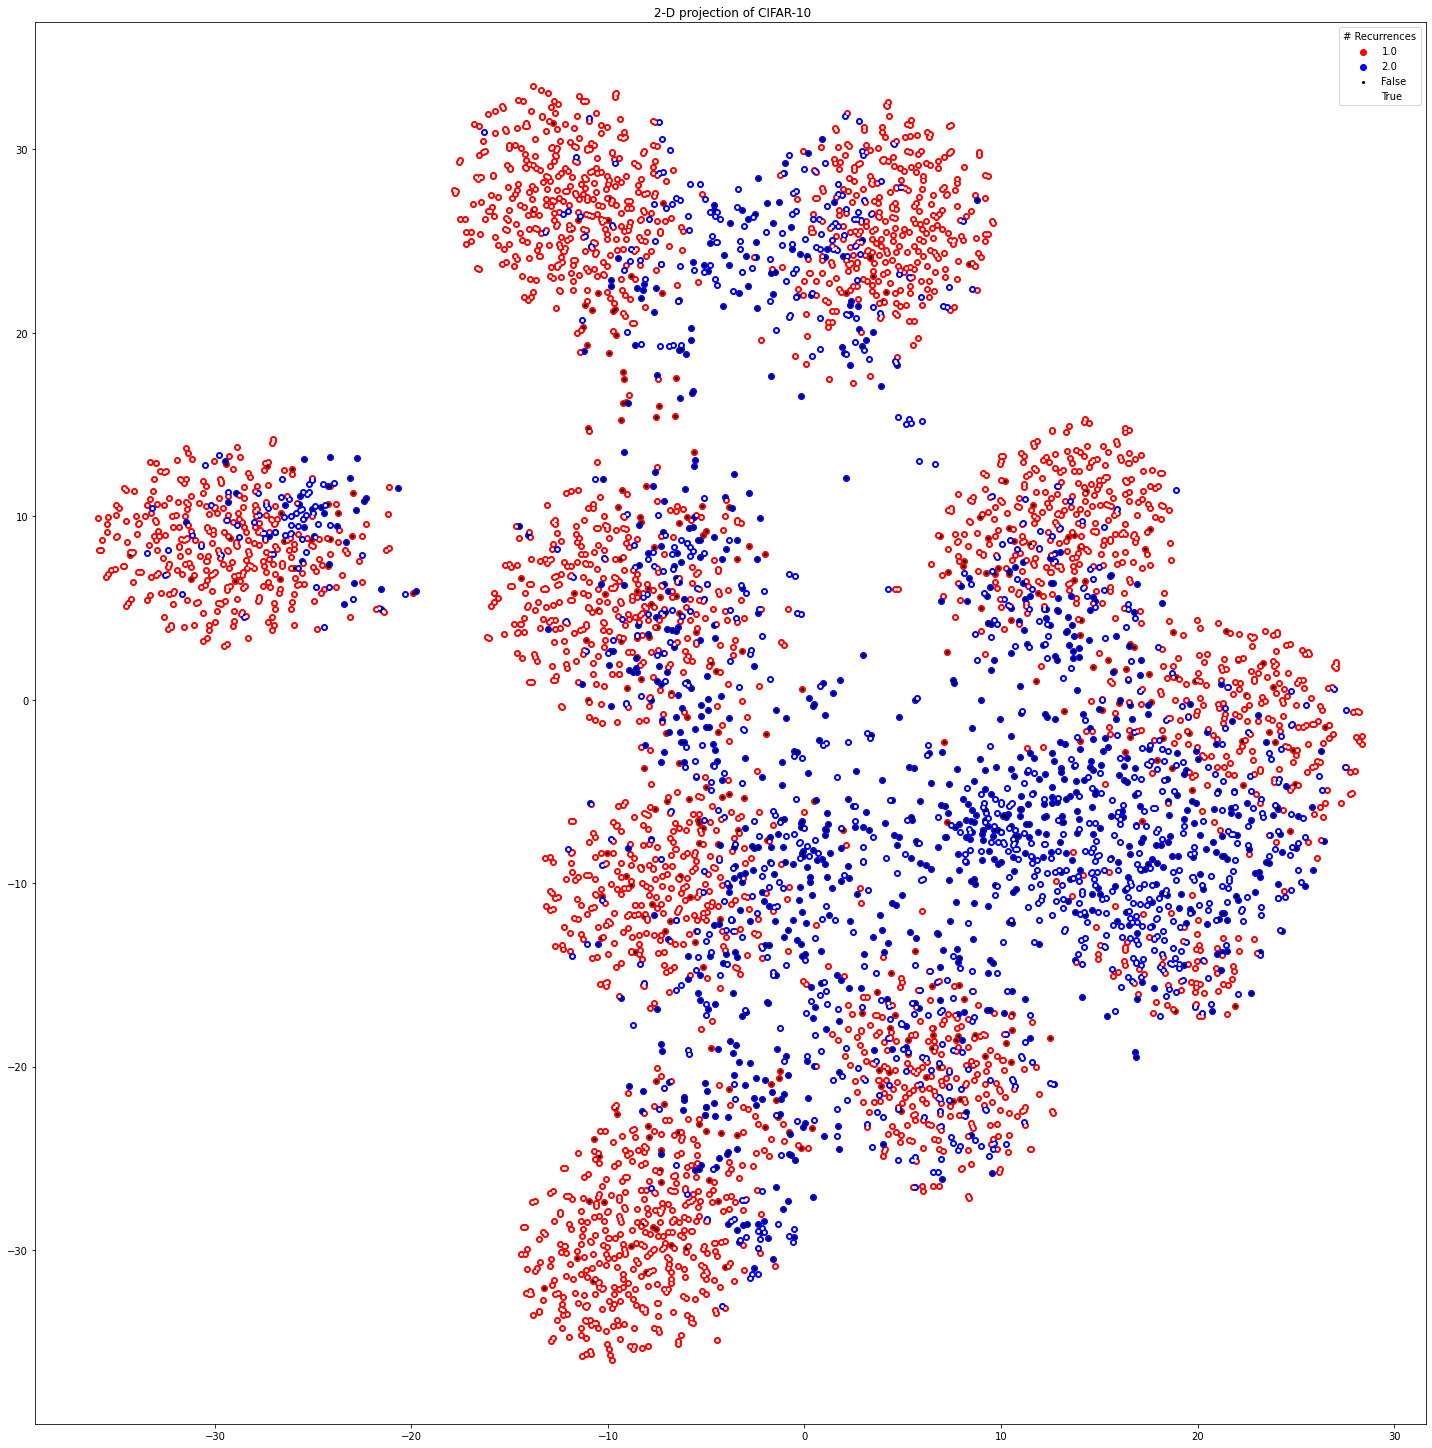

In [62]:
from matplotlib import pyplot as plt
# import plotly.express as px
# fig = px.scatter(tx, ty, color=final_steps.cpu())
# fig.show()


# plt.figure( figsize=(15,15) )
# plt.scatter(tx, ty, c=f_steps.cpu())
# plt.legend(("rec1","rec2"))
# # plt.show()
cdict = {1: 'red', 2: 'blue'}
cdict2 = {False: 'black', True: 'white'}
f_color = f_steps+1
fig, ax = plt.subplots(figsize=(20, 20))
for g in np.unique(f_color):
    ix = np.where(f_color == g)
    ax.scatter(tx[ix], ty[ix], c = cdict[g], label = g)
for g in np.unique(resul):
    ix = np.where(resul == g)
    ax.scatter(tx[ix], ty[ix], c = cdict2[g], label = g ,s=4)
ax.legend(title = "# Recurrences")
fig.tight_layout()
plt.title(" 2-D projection of CIFAR-10")
plt.savefig("2d cifar10 rec lstm.pdf")

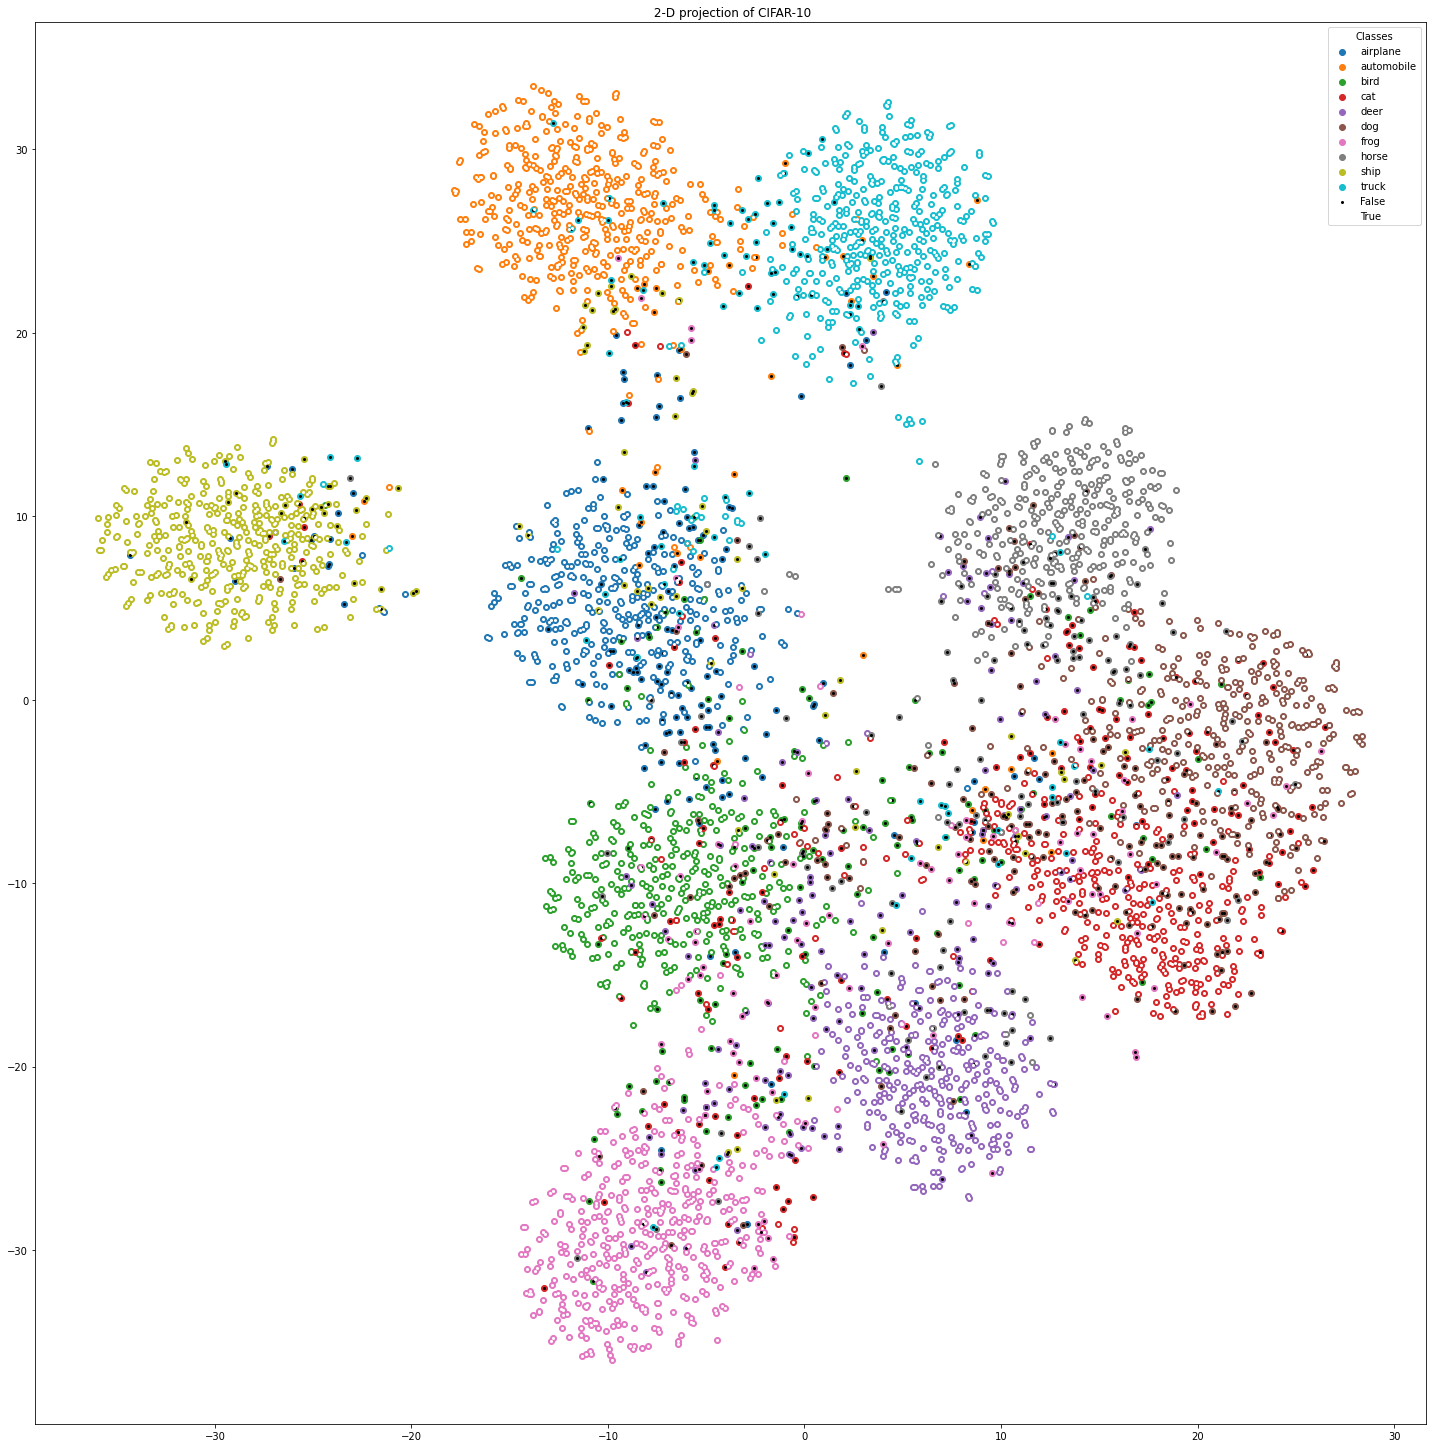

In [61]:
a_labels=all_labels.numpy().astype(int)
label_names= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cdict = {1: 'red', 2: 'blue'}
f_color = f_steps+1
fig, ax = plt.subplots(figsize=(20, 20))
for g in np.unique(a_labels):
    ix = np.where(a_labels == g)
    ax.scatter(tx[ix], ty[ix],  label = label_names[g], cmap='tab10')
for g in np.unique(resul):
    ix = np.where(resul == g)
    ax.scatter(tx[ix], ty[ix], c = cdict2[g], label = g ,s=4)
ax.legend(title = "Classes")
fig.tight_layout()
plt.title(" 2-D projection of CIFAR-10")
plt.savefig("2d cifar10 classes lstm.pdf")

In [48]:
fs2= all_labels[torch.where(f_steps == 1)]
count2 =fs2.unique(return_counts=True)
count2[1]/fs2.size()[0]*100

tensor([ 7.6624,  5.4414,  9.8279, 21.8212, 11.6602, 14.0478,  7.1627,  7.5514,
         5.8856,  8.9395])

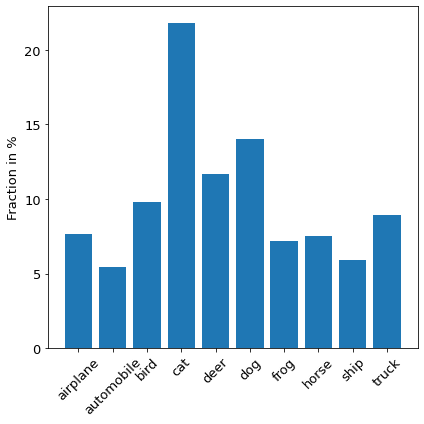

In [65]:
fig, ax = plt.subplots(figsize=(6, 6))
# label_names2= ['$airplane$', '$automobile$', '$bird$', '$cat$', '$deer$', '$dog$', '$frog$', '$horse$', '$ship$', '$truck$']
plt.bar(label_names, count2[1]/fs2.size()[0]*100)
plt.xticks(rotation=45)
# fig.tight_layout()
plt.xticks(fontsize=13 )
plt.yticks(fontsize=13 )
plt.ylabel("Fraction in %", fontsize=13)
fig.tight_layout()
plt.savefig("class dist rec2 lstm.pdf")